In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [2]:
# โหลดข้อมูล
df = pd.read_csv("C:\\Users\\ADMIN\Project\\.venv\\Sleep testFiltered_EEG_Data1.csv")

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5896\2419121426.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("C:\\Users\\ADMIN\Project\\.venv\\Sleep testFiltered_EEG_Data1.csv")


In [3]:
channel_map = {
    "1": "EEG F4-M1",
    "2": "EEG C4-M1",
    "3": "EEG O2-M1",
    "4": "EEG C3-M2",
    "5": "EMG chin",
    "6": "EOG E1-M2",
    "7": "EOG E2-M2",
    "8": "ECG"
}
# เปลี่ยนชื่อ column ใน DataFrame
df = df.rename(columns=channel_map)

# ตรวจสอบ
print(df.head())

       Time  EEG F4-M1  EEG C4-M1  EEG O2-M1  EEG C3-M2  EMG chin  EOG E1-M2  \
0  0.000000  -0.332139   1.460207  -0.082405   0.945965 -0.556532   8.282122   
1  0.003906   0.455678  -0.506964  -8.182390   2.241613  3.137224  18.753385   
2  0.007812  -0.995135  -3.805043 -15.517629   2.785924  5.121238  26.958536   
3  0.011719  -5.017469  -7.255061 -18.758616   1.417463  5.081020  29.945681   
4  0.015625 -10.258652  -9.017413 -16.288979  -2.295541  4.092776  27.027844   

   EOG E2-M2        ECG      Annotation  
0  -6.846270 -36.322502   Sleep stage W  
1  -6.397049 -36.334116   Sleep stage W  
2  -7.204251 -37.603388   Sleep stage W  
3  -9.951360 -42.065282   Sleep stage W  
4 -13.573874 -50.681696   Sleep stage W  


In [4]:
df.shape

(6566400, 10)

In [5]:
data = df.drop(['Annotation','Time'], axis=1)
labels = df['Annotation']

In [8]:
N2,W,R,N1,N3=labels.value_counts()
print(N2+W+R+N1+N3)
print(labels.value_counts())

6558720
Annotation
Sleep stage N2    3302400
Sleep stage W     1159680
Sleep stage R     1082880
Sleep stage N1     837120
Sleep stage N3     176640
Name: count, dtype: int64


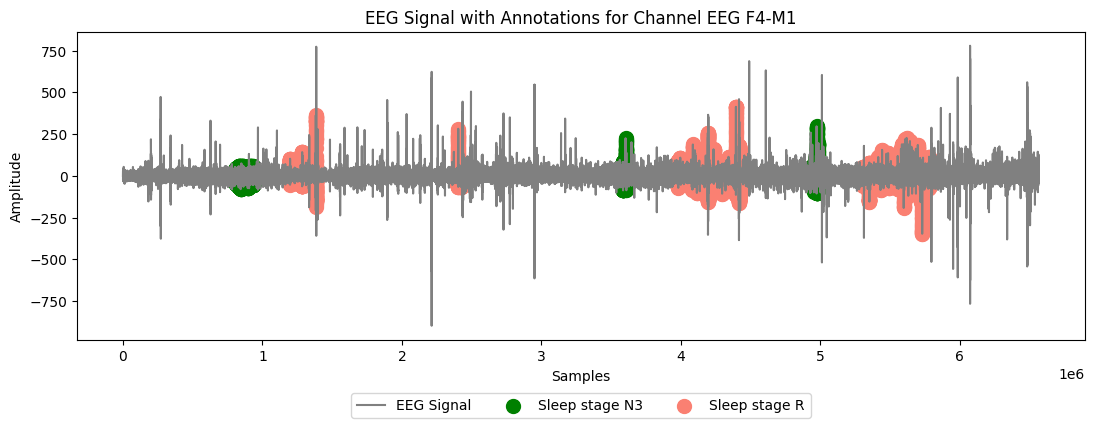

In [20]:
plt.figure(figsize=(13, 4))
plt.plot(df.index, df['EEG F4-M1'], c = 'gray',label='EEG Signal')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage N3'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage N3'], c = 'green', label='Sleep stage N3', s=100, marker='o')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage R'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage R'], c = 'salmon', label='Sleep stage R', s=100, marker='o')

plt.title("EEG Signal with Annotations for Channel EEG F4-M1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

plt.show()

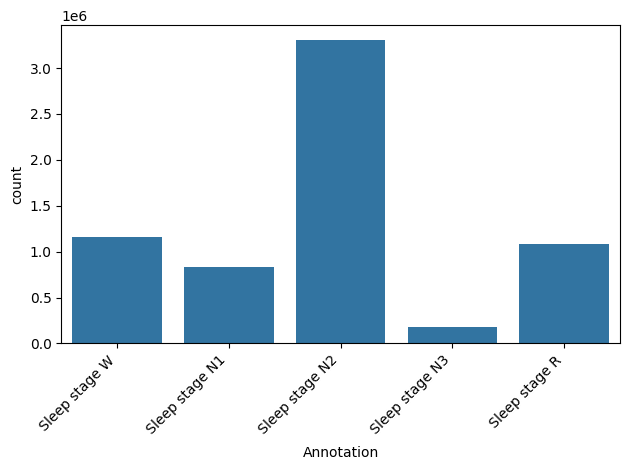

The number of Sleep stage Wake is: 3302400
The number of Sleep stage N1 is: 1159680
The number of Sleep stage N2 is: 1082880
The number of Sleep stage N3 is: 837120
The number of Sleep stage N4 is: 176640


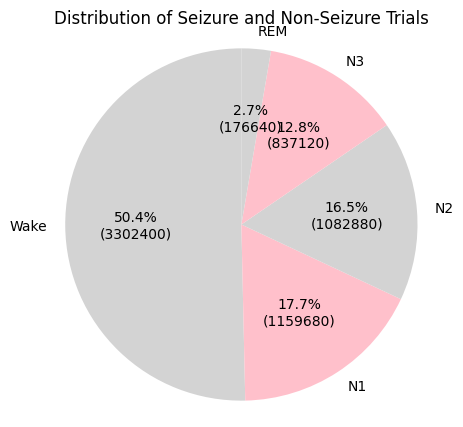

In [ ]:
# Assuming 'labels' is a Series or list containing your label data
sns.countplot(x=labels)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate the number of non-seizure and seizure trials
N2,W,R,N1,N3 = labels.value_counts()

# Print the counts
print('The number of Sleep stage Wake is:', Wake)
print('The number of Sleep stage N1 is:', N1)
print('The number of Sleep stage N2 is:', N2)
print('The number of Sleep stage N3 is:', N3)
print('The number of Sleep stage N4 is:', REM)
# Create a pie chart with percentage and number of samples
labels_counts = [Wake,N1,N2,N3,REM]
labels_names = ['Wake','N1','N2','N3','REM']

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        absolute = int(round(pct/100.*total))
        return f"{pct:.1f}%\n({absolute})"
    return my_format

plt.figure(figsize=(5, 5))
plt.pie(labels_counts, labels=labels_names, autopct=autopct_format(labels_counts), startangle=90, colors=['lightgrey', 'pink'])
plt.title('Distribution of Seizure and Non-Seizure Trials')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()


### Split Data into Training, Validation and Testing Sets

In [6]:
# train-test split for time series
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.8)
X_train_df, X_val_df, X_test_df = data[:train_size], data[train_size+1:val_size], data[val_size+1:]
y_train_df, y_val_df, y_test_df = labels[:train_size], labels[train_size+1:val_size], labels[val_size+1:]
X_train_df.shape, X_val_df.shape, X_test_df.shape, y_train_df.shape, y_val_df.shape, y_test_df.shape

((4596480, 8), (656639, 8), (1313279, 8), (4596480,), (656639,), (1313279,))

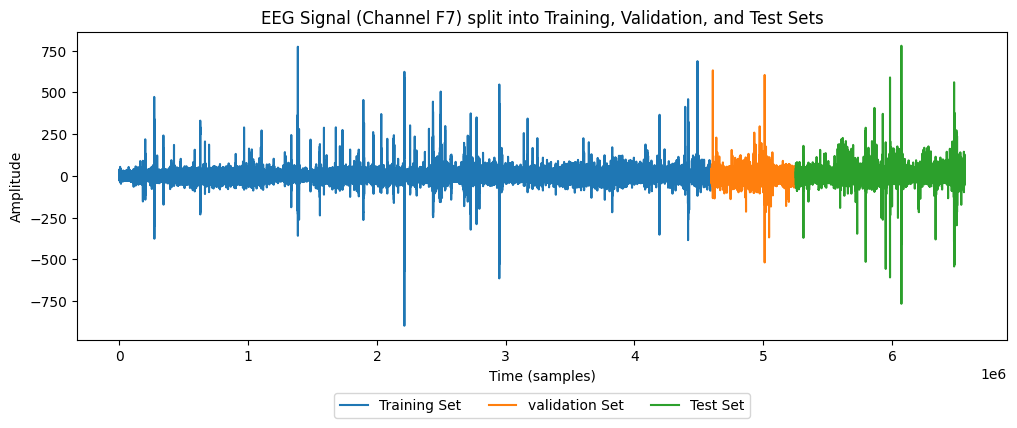

In [7]:
plt.figure(figsize=(12,4))
plt.plot(X_train_df['EEG F4-M1'], label='Training Set')
plt.plot(X_val_df['EEG F4-M1'], label='validation Set')
plt.plot(X_test_df['EEG F4-M1'], label='Test Set')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title("EEG Signal (Channel F7) split into Training, Validation, and Test Sets")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

plt.show()

In [8]:
y_train_df.value_counts(), y_val_df.value_counts(), y_test_df.value_counts()

(Annotation
 Sleep stage N2    2261760
 Sleep stage W      906240
 Sleep stage N1     660480
 Sleep stage R      629760
 Sleep stage N3     138240
 Name: count, dtype: int64,
 Annotation
 Sleep stage N2    587519
 Sleep stage N3     38400
 Sleep stage W      23040
 Sleep stage N1      7680
 Name: count, dtype: int64,
 Annotation
 Sleep stage R     453120
 Sleep stage N2    453119
 Sleep stage W     230400
 Sleep stage N1    168960
 Name: count, dtype: int64)

### Oversampling

In [9]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(sampling_strategy='minority', random_state=42)
X_train_df, y_train_df = smt.fit_resample(X_train_df, y_train_df)

print(y_train_df.value_counts())
print(y_val_df.value_counts())
print(y_test_df.value_counts())

Annotation
Sleep stage N2    2261760
Sleep stage N3    2261760
Sleep stage W      906240
Sleep stage N1     660480
Sleep stage R      629760
Name: count, dtype: int64
Annotation
Sleep stage N2    587519
Sleep stage N3     38400
Sleep stage W      23040
Sleep stage N1      7680
Name: count, dtype: int64
Annotation
Sleep stage R     453120
Sleep stage N2    453119
Sleep stage W     230400
Sleep stage N1    168960
Name: count, dtype: int64


In [10]:
X_train_df.shape, X_val_df.shape, X_test_df.shape

((6720000, 8), (656639, 8), (1313279, 8))

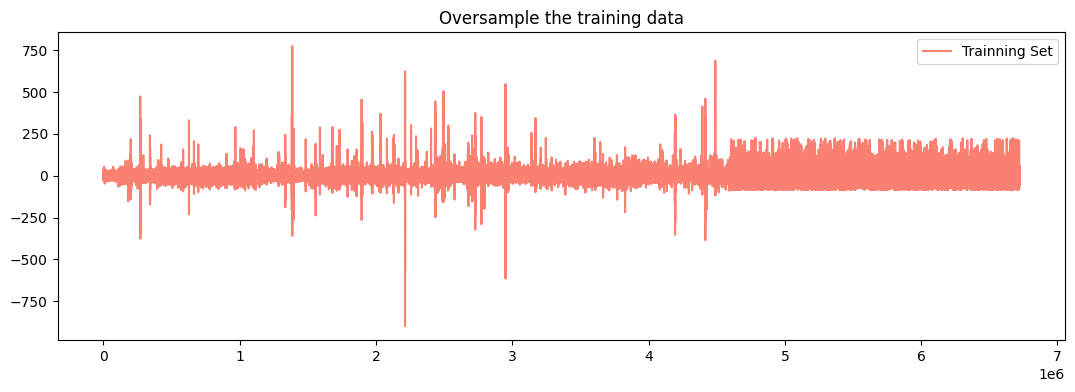

In [11]:
plt.figure(figsize=(13,4))
plt.plot(X_train_df['EEG F4-M1'], color='salmon', label='Trainning Set')
plt.legend()
plt.title('Oversample the training data')
plt.show()

### Select Channel

In [12]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6720000 entries, 0 to 6719999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   EEG F4-M1  float64
 1   EEG C4-M1  float64
 2   EEG O2-M1  float64
 3   EEG C3-M2  float64
 4   EMG chin   float64
 5   EOG E1-M2  float64
 6   EOG E2-M2  float64
 7   ECG        float64
dtypes: float64(8)
memory usage: 410.2 MB


In [13]:
selected_channels = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1','EEG C3-M2']

# Create the new DataFrame with only the selected channels
X_train_df_reduced = X_train_df[selected_channels]
X_val_df_reduced = X_val_df[selected_channels]
X_test_df_reduced = X_test_df[selected_channels]

X_train_df_reduced.shape, X_val_df_reduced.shape, X_test_df_reduced.shape

((6720000, 4), (656639, 4), (1313279, 4))

### Create Sliding Window

In [14]:
def apply_sliding_window(data, label, window_size, step_size):
    # Reset index เพื่อให้ iloc ทำงานชัวร์
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)

    window_data = []
    window_label = []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        label_slice = label.iloc[i:i + window_size]

        if len(label_slice) == 0 or label_slice.mode().empty:
            continue  # ข้าม window ที่ไม่มีข้อมูล

        label_value = label_slice.mode().iloc[0]

        window_data.append(window)
        window_label.append(label_value)

    X = np.array(window_data)
    y = np.array(window_label)
    return X, y


In [ ]:
# Define parameters
window_size = 256
step_size = 128

# Apply sliding window function to the train/test set
X_train, y_train =  apply_sliding_window(X_train_df, y_train_df, window_size, step_size)
X_val, y_val =  apply_sliding_window(X_val_df, y_val_df, window_size, step_size)
X_test, y_test = apply_sliding_window(X_test_df, y_test_df, window_size, step_size)

X_train_reduced, y_train_reduced =  apply_sliding_window(X_train_df_reduced, y_train_df, window_size, step_size)
X_val_reduced, y_val_reduced =  apply_sliding_window(X_val_df_reduced, y_val_df, window_size, step_size)
X_test_reduced, y_test_reduced = apply_sliding_window(X_test_df_reduced, y_test_df, window_size, step_size)

print("X_train:" ,X_train.shape, ", y_train:", y_train.shape)
print("X_val:" ,X_val.shape, ", y_val:", y_val.shape)
print("X_test:" ,X_test.shape, ", y_test:", y_test.shape)

print("X_train_reduced:" ,X_train_reduced.shape, ", y_train_reduced:", y_train_reduced.shape)
print("X_val_reduced:" ,X_val_reduced.shape, ", y_val_reduced:", y_val_reduced.shape)
print("X_test_reduced:" ,X_test_reduced.shape, ", y_test_reduced:", y_test_reduced.shape)

X_train: (33599, 400, 8) , y_train: (33599,)
X_val: (3282, 400, 8) , y_val: (3282,)
X_test: (6528, 400, 8) , y_test: (6528,)
X_train_reduced: (33599, 400, 4) , y_train_reduced: (33599,)
X_val_reduced: (3282, 400, 4) , y_val_reduced: (3282,)
X_test_reduced: (6528, 400, 4) , y_test_reduced: (6528,)


### Train Model

#### Model1

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [17]:
# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))  # เอาจาก train set เท่านั้น

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

# ensure shape = (samples, timesteps, features)
if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง LSTM model
# -----------------------------
model1 = Sequential()
model1.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model1.summary()

# -----------------------------
# 4. Train model
# -----------------------------
history = model1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    shuffle=False,
)

# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model1.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")


X_train shape: (33599, 400, 8)
y_train shape: (33599, 5)


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,055 (47.09 KB)

 Trainable params: 12,055 (47.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.6608 - loss: 0.9844 - val_accuracy: 0.0588 - val_loss: 5.0545
Epoch 2/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 57s 54ms/step - accuracy: 0.6684 - loss: 0.9471 - val_accuracy: 0.0707 - val_loss: 4.3038
Epoch 3/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 60s 57ms/step - accuracy: 0.6708 - loss: 0.9197 - val_accuracy: 0.0960 - val_loss: 4.0472
Epoch 4/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 60s 57ms/step - accuracy: 0.6715 - loss: 0.8985 - val_accuracy: 0.1365 - val_loss: 3.7417
Epoch 5/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 78s 74ms/step - accuracy: 0.6823 - loss: 0.8754 - val_accuracy: 0.1584 - val_loss: 3.4859
Epoch 6/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 75s 71ms/step - accuracy: 0.6894 - loss: 0.8506 - val_accuracy: 0.1935 - val_loss: 2.9663
Epoch 7/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 83s 72ms/step - accuracy: 0.6948 - loss: 0.8401 - val_accuracy: 0.3208 - val_loss: 2.5688
Epoch 8/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 74s 71ms/step - accuracy: 

In [18]:
model1.save("LSTM20unit.h5")

In [19]:
threshold = 0.5  # set the threshold value
y_pred_prob = model1.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


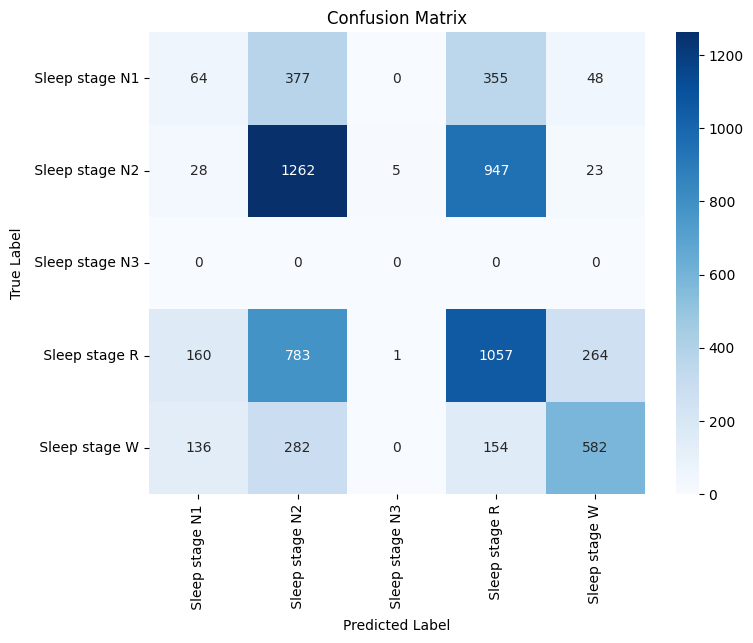

                 precision    recall  f1-score   support

 Sleep stage N1       0.16      0.08      0.10       844
 Sleep stage N2       0.47      0.56      0.51      2265
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.42      0.47      0.44      2265
  Sleep stage W       0.63      0.50      0.56      1154

       accuracy                           0.45      6528
      macro avg       0.34      0.32      0.32      6528
   weighted avg       0.44      0.45      0.44      6528



C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

In [22]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model1.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

#### Model2